In [169]:
#LSTM multivariate input
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
%matplotlib inline
np.set_printoptions(threshold=np.nan)

In [129]:
# dummy data
np.random.seed(1)
df = pd.DataFrame(np.random.rand(100, 4), columns=['price', 'sentiment', 'numberoftweets', 'averagefavourite'])
df['price'] = df['price']*1000
df['numberoftweets'] = df['numberoftweets']*1000
df['averagefavourite'] = df['averagefavourite']*10000
df.head()

,price,sentiment,numberoftweets,averagefavourite
0,417.022005,0.720324,0.114375,3023.325726
1,146.755891,0.092339,186.260211,3455.607270
2,396.767474,0.538817,419.194514,6852.195004
3,204.452250,0.878117,27.387593,6704.675102
4,417.304802,0.558690,140.386939,1981.014891


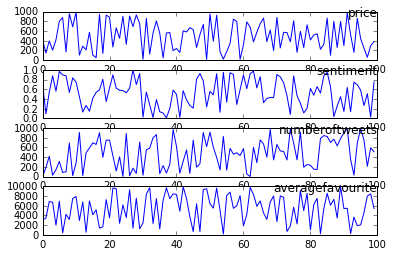

In [171]:
# plot each column
pyplot.figure()
pyplot.subplot(4, 1, 1)
pyplot.plot(df['price'])
pyplot.title('price', y=0.8, loc='right')
pyplot.subplot(4, 1, 2)
pyplot.plot(df['sentiment'])
pyplot.title('sentiment', y=0.8, loc='right')
pyplot.subplot(4, 1, 3)
pyplot.plot(df['numberoftweets'])
pyplot.title('numberoftweets', y=0.8, loc='right')
pyplot.subplot(4, 1, 4)
pyplot.plot(df['averagefavourite'])
pyplot.title('averagefavourite', y=0.8, loc='right')
pyplot.show()

In [130]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [131]:
values = df.values
values = values.astype('float32') # convert to float

In [132]:
values.shape

(100, 4)

In [133]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) # normalised

In [134]:
scaled.shape

(100, 4)

In [135]:
original = scaler.inverse_transform(scaled) # scale back to make sure it's working
original

array([[4.17022003e+02, 7.20324516e-01, 1.14374816e-01, 3.02332568e+03],
       [1.46755890e+02, 9.23385993e-02, 1.86260208e+02, 3.45560718e+03],
       [3.96767487e+02, 5.38816750e-01, 4.19194519e+02, 6.85219482e+03],
       [2.04452255e+02, 8.78117442e-01, 2.73875923e+01, 6.70467529e+03],
       [4.17304810e+02, 5.58689833e-01, 1.40386932e+02, 1.98101489e+03],
       [8.00744568e+02, 9.68261600e-01, 3.13424164e+02, 6.92322607e+03],
       [8.76389160e+02, 8.94606650e-01, 8.50442123e+01, 3.90547821e+02],
       [1.69830414e+02, 8.78142476e-01, 9.83468323e+01, 4.21107617e+03],
       [9.57889526e+02, 5.33165276e-01, 6.91877136e+02, 3.15515625e+03],
       [6.86500916e+02, 8.34625661e-01, 1.82882767e+01, 7.50144336e+03],
       [9.88861084e+02, 7.48165667e-01, 2.80444000e+02, 7.89279346e+03],
       [1.03226006e+02, 4.47893530e-01, 9.08595520e+02, 2.93614160e+03],
       [2.87775330e+02, 1.30028576e-01, 1.93669586e+01, 6.78835547e+03],
       [2.11628113e+02, 2.65546650e-01, 4.91573151e

In [136]:
reframed = series_to_supervised(scaled, 3, 1)
reframed.drop(reframed.columns[[13, 14, 15]], axis=1, inplace=True) # only keep price column
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
3,0.413444,0.718717,0.000000,0.294544,0.136222,0.081017,0.187307,0.338860,0.392668,0.534401,0.421695,0.687066,0.195403
4,0.136222,0.081017,0.187307,0.338860,0.392668,0.534401,0.421695,0.687066,0.195403,0.878951,0.027443,0.671943,0.413734
5,0.392668,0.534401,0.421695,0.687066,0.195403,0.878951,0.027443,0.671943,0.413734,0.554582,0.141148,0.187690,0.807042
6,0.195403,0.878951,0.027443,0.671943,0.413734,0.554582,0.141148,0.187690,0.807042,0.970489,0.315265,0.694348,0.884633
7,0.413734,0.554582,0.141148,0.187690,0.807042,0.970489,0.315265,0.694348,0.884633,0.895695,0.085460,0.024641,0.159891


In [137]:
# train and test set
split = 0.9
reframed_values = reframed.values
train = reframed_values[:int(len(reframed_values)*split), :]
test = reframed_values[int(len(reframed_values)*split):, :]
test.shape

(10, 13)

In [138]:
n_hours = 3
n_features = 4
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

(87, 12) (87,)


In [139]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [140]:
test_X.shape

(10, 3, 4)

In [141]:
# LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))) # LSTM layer, 100 units
model.add(Dense(1)) # fully connected layer
model.compile(loss='mae', optimizer='adam') # configure training process, mean absolute error

In [142]:
# iterate training batches
history = model.fit(train_X, train_y, epochs=50, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 87 samples, validate on 10 samples
Epoch 1/50
 - 1s - loss: 0.3430 - val_loss: 0.2386
Epoch 2/50
 - 0s - loss: 0.2770 - val_loss: 0.2753
Epoch 3/50
 - 0s - loss: 0.2687 - val_loss: 0.2475
Epoch 4/50
 - 0s - loss: 0.2692 - val_loss: 0.2530
Epoch 5/50
 - 0s - loss: 0.2677 - val_loss: 0.2649
Epoch 6/50
 - 0s - loss: 0.2656 - val_loss: 0.2587
Epoch 7/50
 - 0s - loss: 0.2640 - val_loss: 0.2505
Epoch 8/50
 - 0s - loss: 0.2630 - val_loss: 0.2648
Epoch 9/50
 - 0s - loss: 0.2607 - val_loss: 0.2670
Epoch 10/50
 - 0s - loss: 0.2591 - val_loss: 0.2637
Epoch 11/50
 - 0s - loss: 0.2576 - val_loss: 0.2603
Epoch 12/50
 - 0s - loss: 0.2560 - val_loss: 0.2576
Epoch 13/50
 - 0s - loss: 0.2541 - val_loss: 0.2558
Epoch 14/50
 - 0s - loss: 0.2530 - val_loss: 0.2504
Epoch 15/50
 - 0s - loss: 0.2513 - val_loss: 0.2527
Epoch 16/50
 - 0s - loss: 0.2478 - val_loss: 0.2331
Epoch 17/50
 - 0s - loss: 0.2523 - val_loss: 0.2369
Epoch 18/50
 - 0s - loss: 0.2444 - val_loss: 0.2325
Epoch 19/50
 - 0s - loss: 0.2

In [143]:
model.save("./model") # save model

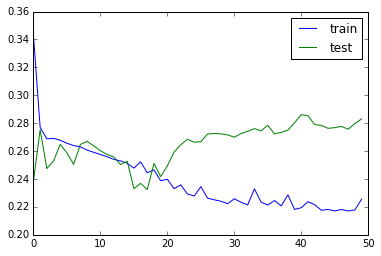

In [144]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [145]:
# keras.models.load_model("./model")
yhat = model.predict(test_X)

In [146]:
yhat

array([[0.22340643],
       [0.5376177 ],
       [0.2974965 ],
       [0.6139757 ],
       [0.65839255],
       [0.15566728],
       [0.5141466 ],
       [0.40084252],
       [0.69333166],
       [0.46901464]], dtype=float32)

In [150]:
# invert scaling for forecast
test_X_reshape = test_X.reshape((len(test_X), -1))
test_X_reshape

array([[0.80588365, 0.02235579, 0.77492994, 0.73474556, 0.2520714 ,
        0.2482956 , 0.63613385, 0.3385899 , 0.8027792 , 0.44029734,
        0.7875187 , 1.        ],
       [0.2520714 , 0.2482956 , 0.63613385, 0.3385899 , 0.8027792 ,
        0.44029734, 0.7875187 , 1.        , 0.293665  , 0.13246775,
        0.9068175 , 0.5397907 ],
       [0.8027792 , 0.44029734, 0.7875187 , 1.        , 0.293665  ,
        0.13246775, 0.9068175 , 0.5397907 , 0.98551583, 0.6337017 ,
        0.99999994, 0.54441565],
       [0.293665  , 0.13246775, 0.9068175 , 0.5397907 , 0.98551583,
        0.6337017 , 0.99999994, 0.54441565, 0.5256635 , 0.12477259,
        0.3578097 , 0.01148142],
       [0.98551583, 0.6337017 , 0.99999994, 0.54441565, 0.5256635 ,
        0.12477259, 0.3578097 , 0.01148142, 0.15021251, 0.744421  ,
        0.0304743 , 0.3603702 ],
       [0.5256635 , 0.12477259, 0.3578097 , 0.01148142, 0.15021251,
        0.744421  , 0.0304743 , 0.3603702 , 0.8702291 , 0.69064236,
        0.6951385 ,

In [160]:
inv_yhat = np.concatenate((yhat, test_X_reshape[:, :3]), axis=1)
inv_yhat

array([[0.22340643, 0.80588365, 0.02235579, 0.77492994],
       [0.5376177 , 0.2520714 , 0.2482956 , 0.63613385],
       [0.2974965 , 0.8027792 , 0.44029734, 0.7875187 ],
       [0.6139757 , 0.293665  , 0.13246775, 0.9068175 ],
       [0.65839255, 0.98551583, 0.6337017 , 0.99999994],
       [0.15566728, 0.5256635 , 0.12477259, 0.3578097 ],
       [0.5141466 , 0.15021251, 0.744421  , 0.0304743 ],
       [0.40084252, 0.8702291 , 0.69064236, 0.6951385 ],
       [0.69333166, 0.43896657, 0.57782346, 0.9958127 ],
       [0.46901464, 0.23979798, 0.25347835, 0.75473845]], dtype=float32)

In [161]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat

array([[2.3175262e+02, 8.0616355e-01, 2.2331528e+01, 7.7092661e+03],
       [5.3808020e+02, 2.6078758e-01, 2.4687021e+02, 6.3553755e+03],
       [3.0398373e+02, 8.0310637e-01, 4.3768130e+02, 7.8320635e+03],
       [6.1252234e+02, 3.0174756e-01, 1.3176064e+02, 8.9957666e+03],
       [6.5582477e+02, 9.8305935e-01, 6.2988629e+02, 9.9047168e+03],
       [1.6571307e+02, 5.3021199e-01, 1.2411321e+02, 3.6404546e+03],
       [5.1519806e+02, 1.6048029e-01, 7.3991901e+02, 4.4745218e+02],
       [4.0473676e+02, 8.6952883e-01, 6.8647382e+02, 6.9309385e+03],
       [6.8988721e+02, 4.4483575e-01, 5.7435455e+02, 9.8638730e+03],
       [4.7119839e+02, 2.4870110e-01, 2.5202083e+02, 7.5123076e+03]],
      dtype=float32)

In [ ]:
inv_yhat = inv_yhat[:,0]
inv_yhat

In [165]:
# invert scaling for actual
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [166]:
inv_y

array([300.24835, 974.74036, 526.42596, 160.39517, 862.34625, 441.90427,
       247.7329 ,  56.92944, 297.3314 , 381.0161 ], dtype=float32)

In [167]:
test_y

array([0.293665  , 0.98551583, 0.5256635 , 0.15021251, 0.8702291 ,
       0.43896657, 0.23979798, 0.04408395, 0.29067296, 0.3765114 ],
      dtype=float32)

In [170]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 303.799


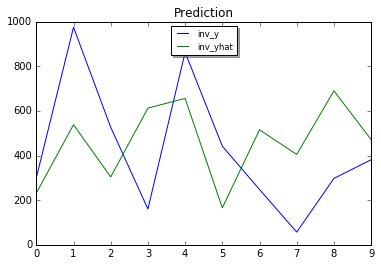

In [178]:
pyplot.plot(inv_y, label='inv_y')
pyplot.plot(inv_yhat, label='inv_yhat')
pyplot.title('Prediction')
pyplot.legend(loc='upper center', shadow=True, fontsize='small')
pyplot.show()